<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/clusters/workflow_unsupervised_learning_clusteripynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Faker
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# -- data faker --
from datetime import date, datetime
from random import randint, sample, choices
from faker.providers.address import es_CO as co_provider
from faker.providers.ssn import es_CO as co_ssn


import random
from matplotlib.colors import ListedColormap



# -- data --
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder 

# -- graficos --
import matplotlib.pyplot as plt
import seaborn as sns


# --models
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.cluster import KMeans, BisectingKMeans

from sklearn.metrics import silhouette_score

In [3]:
random.seed(42)

# **Data generator**

In [4]:
# Date generator

seed = 500

def generate_date(start_year):
  start_date = datetime(start_year, 1, 1).replace(day=1, month=1).toordinal()
  end_date = date.today().toordinal()
  date_gen = date.fromordinal(randint(start_date, end_date))
  return date_gen.isoformat()


date_fake = list(map(lambda x: generate_date(2022), range(0,seed)))
date_fake.sort(key=lambda date: datetime.strptime(date, "%Y-%m-%d"))

In [5]:
# Money generator
money = sample(list(range(500000, 10000000)),seed)

In [6]:
# Jurisdiction generator
jurisdicciones = list(map(lambda x: choices(list(co_provider.Provider.departments.values()))[0], range(seed)))

In [7]:
# Generador cedula
nit = [1416184,15616515,151178,95959,15151,77474,1616,848489,11818941,118918941,16447496,6164684,16184,618484,14894,6519618,7474984,1313185168,18479841,161798,1747894,9559,141616,89746468,48484,16516,747087,1618,789965]
nit = list(map(lambda x: choices(list(nit))[0], range(seed)))

In [8]:
data = pd.DataFrame()
data['nit'] = nit
data['date'] = date_fake
data['money'] = money
data['jurisdictions'] = jurisdicciones

# **Functions**
---
They are hidden to reduce the cognitive load of the code.

In [9]:
def plot_select_params(best_score, best_x_param, scores, x_params, **kwards):
  fig, ax = plt.subplots(1, 1, figsize=(8, 5))
  ax.plot(x_params, scores)
  ax.plot(best_x_param, best_score, marker='o', color='r')
  ax.axvline(x=best_x_param,  color='r')
  ax.set_title(kwards['title'])
  ax.set_xlabel(kwards['xlabel'])
  ax.set_ylabel(kwards['ylabel'])


def silhouette_select_cluster(model, clusters, data, **kwards):
  """Metodo silhouette"""
  range_n_clusters = range(clusters[0], clusters[1])
  valores_medios_silhouette = {}
  for k in range_n_clusters:
    model.n_clusters = k 
    model.fit(data)
    y_predict = model.predict(data)
    silhouette_avg = silhouette_score(data, y_predict)
    valores_medios_silhouette[k] = silhouette_avg
  
  x = list(range_n_clusters)
  y = list(valores_medios_silhouette.values())
  kneedle = KneeLocator(x, y, S=1.0, curve="concave", direction="increasing")

  best_score = valores_medios_silhouette[kneedle.elbow]
  best_cluster = kneedle.elbow

  res_data = {
      'score': best_score,
      'cluster': best_cluster,
  }
  plot_select_params(best_score, best_cluster, y, range_n_clusters,
                        title = f'Evolución de media de los índices silhouette {kwards["name_model"]}',
                        ylabel = 'Media índices silhouette',
                        xlabel = 'Numero clusters')
  
  return best_cluster, best_score


def pie_circle(serie:pd.Series, paleta=None, figsize_x:int=7, figsize_y:int=7,fontsize=15,**kwards)->None:
  paleta = paleta if paleta !=None else generate_colors()[0]
  values = serie.value_counts().sort_index()
  names = values.index
  size = values.values
  fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
  fig.suptitle(f'Diagrama de anillo {kwards["title"]}', fontsize=fontsize)
  my_circle = plt.Circle( (0,0), 0.7, color='white')
  plt.pie(size, labels=names, autopct="%0.1f %%", wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, colors = paleta)
  p = plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()



def generate_colors(paleta="Set1", n_colors=15):
  """Generador de colores"""
  cmap = sns.color_palette(paleta, n_colors).as_hex()
  list_camap = ListedColormap(cmap)
  return cmap, list_camap

# **DATA**
---

In [10]:
data.head()

,nit,date,money,jurisdictions
0,9559,2022-01-01,1654126,Risaralda
1,1616,2022-01-02,4598412,"Archipiélago de San Andrés, Providencia y Sant..."
2,141616,2022-01-02,6699635,Guaviare
3,151178,2022-01-04,5281295,Magdalena
4,18479841,2022-01-04,3146552,Meta


In [11]:
# Change data type date
data['date'] = data['date'].astype('datetime64[ns]')

In [12]:
# Extraction of the year and month
data['year'] = data['date'].apply(lambda x: x.year)
data['month'] = data['date'].apply(lambda x: x.month)

In [13]:
# First grouping
# Group by nit, year and month
data_group = data.groupby(["year", "month", "nit"]).agg({'month': ['count', 'mean'], 'money': ['sum', 'mean']})

In [14]:
data_group_pos = pd.DataFrame(data_group.values)
data_group_pos.index = data_group.index
data_group_pos.reset_index(inplace=True)

In [15]:
data_group_pos.columns = ['year', 'month_active', 'nit', 'number_transactions', 'number_transactions_average_month', 'amount', 'amountXmonth']
data_group_pos.head()

,year,month_active,nit,number_transactions,number_transactions_average_month,amount,amountXmonth
0,2022,1,1616,1.0,1.0,4598412.0,4598412.0
1,2022,1,1618,2.0,1.0,3739232.0,1869616.0
2,2022,1,9559,1.0,1.0,1654126.0,1654126.0
3,2022,1,15151,2.0,1.0,7959312.0,3979656.0
4,2022,1,16516,1.0,1.0,4928914.0,4928914.0


In [16]:
# Example of grouping for a single example
data_group_pos[data_group_pos["nit"] == 11818941]

,year,month_active,nit,number_transactions,number_transactions_average_month,amount,amountXmonth
33,2022,2,11818941,1.0,2.0,7675395.0,7675395.0
51,2022,3,11818941,1.0,3.0,4240036.0,4240036.0
69,2022,4,11818941,2.0,4.0,3582063.0,1791031.5
125,2022,7,11818941,1.0,7.0,5152512.0,5152512.0
143,2022,8,11818941,1.0,8.0,8691131.0,8691131.0
159,2022,9,11818941,3.0,9.0,22013211.0,7337737.0
183,2022,10,11818941,1.0,10.0,3827421.0,3827421.0
200,2022,11,11818941,2.0,11.0,14284687.0,7142343.5
234,2023,1,11818941,2.0,1.0,6426577.0,3213288.5
248,2023,2,11818941,1.0,2.0,5470190.0,5470190.0


In [17]:
data_group_pos.columns

Index(['year', 'month_active', 'nit', 'number_transactions',
       'number_transactions_average_month', 'amount', 'amountXmonth'],
      dtype='object')

In [18]:
# First grouping
# Group by nit
data_groupII = data_group_pos.groupby(["nit"]).agg({'number_transactions': ['count', 'sum', 'mean'], 'amount': ['sum', 'mean']})
data_group_posII = pd.DataFrame(data_groupII.values)
data_group_posII.index = data_groupII.index
data_group_posII.reset_index(inplace=True)

In [19]:
data_group_posII.columns = ['nit', 'month_active', 'number_transactions', 'number_transactions_average_month', 'amount', 'amountXmonth']
data_group_posII.head()

,nit,month_active,number_transactions,number_transactions_average_month,amount,amountXmonth
0,1616,11.0,15.0,1.363636,82174651.0,7.470423e+06
1,1618,13.0,22.0,1.692308,114054981.0,8.773460e+06
2,9559,5.0,8.0,1.600000,35041267.0,7.008253e+06
3,14894,7.0,13.0,1.857143,59941587.0,8.563084e+06
4,15151,12.0,22.0,1.833333,106609643.0,8.884137e+06


In [20]:
# Example of grouping for a second example
data_group_posII[data_group_posII["nit"] == 11818941]

,nit,month_active,number_transactions,number_transactions_average_month,amount,amountXmonth
22,11818941,12.0,18.0,1.5,96804410.0,8.067034e+06


- The client 11818941 was active for 12 months, where he made 20 transactions

# **Models**
---

Select features
- month_active
- number_transactions
- number_transactions_average_month
- amount
- valorXmes


Let´s Supongamos that we have a risk variable, related to the jurisdictions or states
- risk

In [21]:
risk = list(map(lambda x: choices(['High', 'Medium', 'Low'])[0], range(data_group_posII.shape[0])))

In [22]:
data_group_posII['risk'] = risk
data_group_posII

,nit,month_active,number_transactions,number_transactions_average_month,amount,amountXmonth,risk
0,1616,11.0,15.0,1.363636,82174651.0,7.470423e+06,Medium
1,1618,13.0,22.0,1.692308,114054981.0,8.773460e+06,Low
2,9559,5.0,8.0,1.600000,35041267.0,7.008253e+06,Medium
3,14894,7.0,13.0,1.857143,59941587.0,8.563084e+06,Medium
4,15151,12.0,22.0,1.833333,106609643.0,8.884137e+06,Medium
5,16184,7.0,17.0,2.428571,94100264.0,1.344289e+07,Medium
6,16516,10.0,14.0,1.400000,82280161.0,8.228016e+06,Medium
7,48484,11.0,11.0,1.000000,66392089.0,6.035644e+06,Medium
8,77474,11.0,18.0,1.636364,105151387.0,9.559217e+06,High
9,95959,9.0,20.0,2.222222,118642270.0,1.318247e+07,High


In [23]:
data_group_posII['risk'] = data_group_posII['risk'].replace({'High':3, 'Medium': 2, 'Low':1})

In [24]:
# KMeans
model = KMeans(init = "k-means++", n_init = 10, max_iter = 300, random_state = 42, algorithm = 'lloyd')

In [25]:
# Data Split
X = data_group_posII.iloc[:, 1:]

(3, 0.5532100962577491)

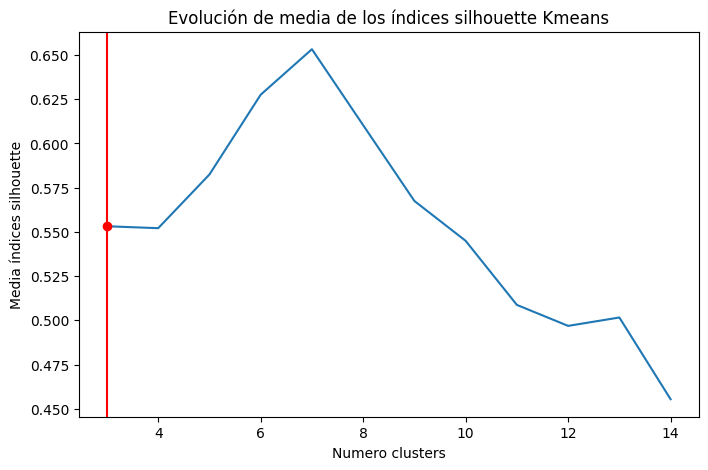

In [26]:
silhouette_select_cluster(model, (3,15), X, name_model = 'Kmeans')

In [27]:
model = BisectingKMeans(init='random', random_state=42, max_iter=300, algorithm="lloyd", bisecting_strategy="biggest_inertia")

(3, 0.49979412312281873)

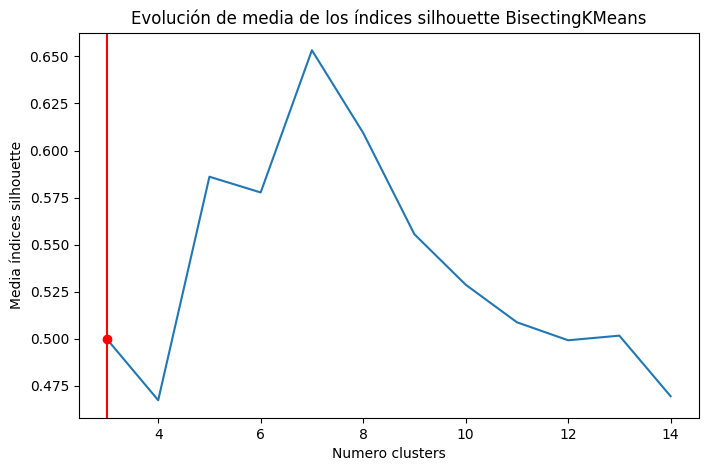

In [28]:
silhouette_select_cluster(model, (3,15), X, name_model = 'BisectingKMeans')

- The eight-segment kmeans will be selected
- The eight-segment BisectingKMeans will be selected

In [29]:
model_k = KMeans(init = "k-means++", n_init = 10, max_iter = 300, random_state = 42, algorithm = 'lloyd')
segmento = model_k.fit_predict(X)
data_group_posII["segmento"] = segmento

In [30]:
silhouette_score(X, segmento)

0.6103425139262273

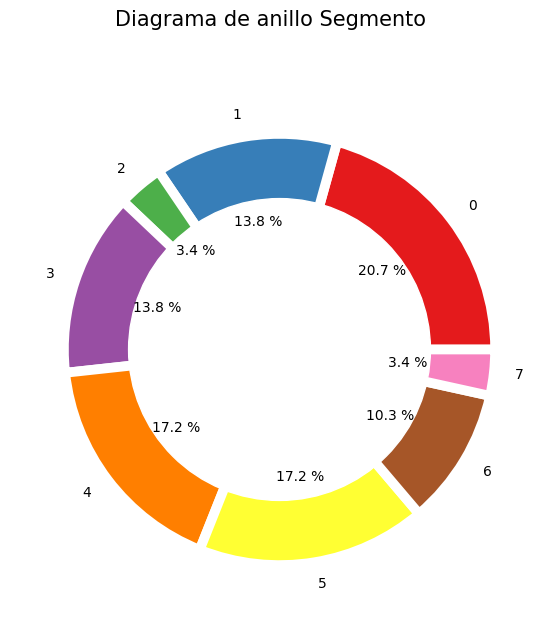

In [31]:
pie_circle(data_group_posII['segmento'], paleta=None, title='Segmento')

In [32]:
pd.options.display.float_format = '{:.2f}'.format

In [56]:
data_group_posII[data_group_posII['segmento'] == 7].describe()

,nit,month_active,number_transactions,number_transactions_average_month,amount,amountXmonth,risk,segmento
count,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
mean,9559.00,5.00,8.00,1.60,35041267.00,7008253.40,2.00,7.00
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,9559.00,5.00,8.00,1.60,35041267.00,7008253.40,2.00,7.00
25%,9559.00,5.00,8.00,1.60,35041267.00,7008253.40,2.00,7.00
50%,9559.00,5.00,8.00,1.60,35041267.00,7008253.40,2.00,7.00
75%,9559.00,5.00,8.00,1.60,35041267.00,7008253.40,2.00,7.00
max,9559.00,5.00,8.00,1.60,35041267.00,7008253.40,2.00,7.00


In [57]:
dta_desc_example = data_group_posII[data_group_posII['segmento'] == 7]
dta_desc_example['risk'].value_counts()/dta_desc_example.shape[0]

2   1.00
Name: risk, dtype: float64

Los valores cuantitativos serán en terminos de promedios.

En el segmento cero hay seis clientes, los cuales estuvieron activos durante 11 meses, en donde realizaron en promedio un total de 16 transacciones por un monto de 82605182.33, en el periodo de actividad, donde por cada mes se hizo una transacción por un monto de 7725111.94. Donde el 67% de los clientes son de riesgo 2(Medio), el 17% riesgo 3 (Alto) y un 17% de riesgo 1 (Bajo).

En el segmento uno hay cuatro clientes, los cuales estuvieron activos durante 11 meses, en donde realizaron en promedio un total de 19 transacciones por un monto de 106687673.00, en el periodo de actividad, donde por cada mes se hicieron dos transacciones por un monto de 9738781.94. Donde el 25% de los clientes son de riesgo 2(Medio), el 50% riesgo 3 (Alto) y un 25% de riesgo 1 (Bajo).

En el segmento dos hay un cliente, el cual estuvo activos durante 7 meses, en donde realizaron en promedio un total de 9 transacciones por un monto de 45802489.00, en el periodo de actividad, donde por cada mes se hizo una trabsacción por un monto de 6543212.71. Donde el 100% es de riesgo 2 (Medio).

En el segmento tres hay cuatro clientes, los cuales estuvieron activos durante 12 meses, en donde realizaron en promedio un total de 22 transacciones por un monto de 131461094.50, en el periodo de actividad, donde por cada mes se hicieron 2 transacciones por un monto de 11294287.38. Donde el 75% de los clientes son de riesgo 2(Medio) y el 25% riesgo 1 (bajo).

En el segmento cuatro hay cinco clientes, los cuales estuvieron activos durante 8 meses, en donde realizaron en promedio un total de 11 transacciones por un monto de 61632777.60, en el periodo de actividad, donde por cada mes se hizo 1 transaccion por un monto de 7762304.67. Donde el 40% de los clientes son de riesgo 2(Medio), el 40% riesgo 1 (bajo) y el 20% es de riesgo alto.

En el segmento cinco hay cinco clientes, los cuales estuvieron activos durante 10 meses, en donde realizaron en promedio un total de 17 transacciones por un monto de 96600844.40, en el periodo de actividad, donde por cada mes se hicieron 2 transacciones por un monto de 9496201.47. Donde el 40% de los clientes son de riesgo 2(Medio), el 40% riesgo 3(Alto) y el 20% de riesgo 1 (Bajo).

En el segmento seis hay 3 clientes, los cuales estuvieron activos durante 11 meses, en donde realizaron en promedio un total de 22 transacciones por un monto de 115910248.67, en el periodo de actividad, donde por cada mes se hicieron 2 transacciones por un monto de 10514019.70. Donde el 33% de los clientes son de riesgo 2(Medio), el 33% riesgo 3(Alto) y el 33% de riesgo 1 (Bajo).

En el segmento siete hay 1 cliente, los cuales estuvieron activos durante 5 meses, en donde realizaron en promedio un total de 8 transacciones por un monto de 35041267.00, en el periodo de actividad, donde por cada mes se hicieron 2 transacciones por un monto de 7008253.40. Donde el 100% son de riesgo medio.
